# 🌊 Mapa de Anomalía TSM — Estilo CIIFEN
## Predicción Estacional NMME + ECMWF (MAM 2026)
**Replica el boletín mensual de CIIFEN: https://www.ciifen.org**

In [ ]:
# ─────────────────────────────────────────────
# INSTALACIÓN (ejecutar solo una vez en Colab)
# ─────────────────────────────────────────────
!pip install cartopy xarray netCDF4 scipy --quiet
print('✅ Instalación completa')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
✅ Instalación completa


In [ ]:
# ─────────────────────────────────────────────
# IMPORTACIONES
# ─────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')
print('✅ Librerías cargadas')

✅ Librerías cargadas


In [ ]:
# ─────────────────────────────────────────────
# COLORMAP OFICIAL (igual al de CPC/CIIFEN)
# ─────────────────────────────────────────────
colores = [
    '#0a0080','#0000ff','#0080ff','#00c0ff',
    '#80ffff','#c0ffff','#ffffff',
    '#ffffc0','#ffff80','#ffff00',
    '#ffc000','#ff8000','#ff0000',
    '#c00000','#800000'
]
cmap_atsm = mcolors.LinearSegmentedColormap.from_list('atsm_ciifen', colores, N=256)
norm_atsm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)
print('✅ Colormap creado')

✅ Colormap creado


In [ ]:
# ─────────────────────────────────────────────
# GENERAR DATOS DE ANOMALÍA TSM
#
# Opción 1: Datos sintéticos (sin internet)
# Opción 2: ERSSTv5 real (descomentar abajo)
# ─────────────────────────────────────────────

def generar_anomalia(escenario='nmme'):
    lon = np.linspace(0, 358, 180)
    lat = np.linspace(-65, 25, 46)
    LON, LAT = np.meshgrid(lon, lat)
    anom = np.zeros_like(LON)

    if escenario == 'nmme':
        # Pacífico Oriental: +0.5°C
        m = (LON > 230) & (LON < 280) & (np.abs(LAT) < 12)
        anom[m] += 0.45 * np.exp(-((LAT[m])/9)**2)
        # Pacífico Central: neutro/leve
        m2 = (LON > 175) & (LON < 230) & (np.abs(LAT) < 8)
        anom[m2] += 0.15
        # Atlántico N
        m3 = (LON > 300) & (LON < 360) & (LAT > 5) & (LAT < 30)
        anom[m3] += 0.3
        titulo = 'NMME ENSEMBLE* AVERAGE'
        fuente = '*ENS: CFSv2, CMC1, CMC2, GFDL, GFDLFLOR, MCAR, GESM, NCAR, CCSM4, NASA'

    elif escenario == 'ecmwf':
        # Pacífico Oriental+Central: hasta +1°C
        m = (LON > 200) & (LON < 280) & (np.abs(LAT) < 12)
        anom[m] += 0.8 * np.exp(-((LAT[m])/8)**2)
        m2 = (LON > 170) & (LON < 200) & (np.abs(LAT) < 8)
        anom[m2] += 0.5
        m3 = (LON > 300) & (LON < 360) & (LAT > 0) & (LAT < 35)
        anom[m3] += 0.4
        titulo = 'ECMWF ENSEMBLE* MEAN'
        fuente = '*Ensamble de 51 miembros'

    anom = gaussian_filter(anom, sigma=2.5)
    return lon, lat, anom, titulo, fuente

print('✅ Función generadora lista')

✅ Función generadora lista


In [ ]:
# ─────────────────────────────────────────────
# FUNCIÓN DE GRAFICADO — ESTILO CIIFEN
# ─────────────────────────────────────────────

def graficar_panel(ax, lon, lat, anom, titulo, fuente,
                   trimestre='Marzo 2026 a Mayo 2026', ic='IC:2026FEB'):

    proj_data = ccrs.PlateCarree()

    # Datos: rotar para centrar en Pacífico
    lon_c = np.where(lon > 180, lon - 360, lon)
    idx   = np.argsort(lon_c)
    lon_c = lon_c[idx]
    anom_c = anom[:, idx]

    im = ax.pcolormesh(
        lon_c, lat, anom_c,
        transform=proj_data,
        cmap=cmap_atsm, norm=norm_atsm,
        shading='auto'
    )

    ax.add_feature(cfeature.LAND,      facecolor='black', zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3, edgecolor='gray', zorder=4)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.2, edgecolor='gray', zorder=4)
    ax.set_extent([-180, 180, -65, 25], crs=proj_data)

    gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                      color='gray', alpha=0.4, linestyle='--')
    gl.top_labels   = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(range(-180, 181, 40))
    gl.ylocator = mticker.FixedLocator(range(-60, 26, 20))
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}

    cbar = plt.colorbar(im, ax=ax, orientation='vertical',
                        fraction=0.022, pad=0.01, extend='both',
                        ticks=[-3,-2,-1,0,1,2,3])
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label('°C', fontsize=8)

    ax.set_title(f'{titulo}\nPredicción Estacional Anomalía TSM (°C)\n{trimestre}',
                 fontsize=7.5, fontweight='bold', pad=4)
    ax.text(0.01, -0.07, f'Fuente de datos: {fuente}',
            transform=ax.transAxes, fontsize=5, color='gray')
    ax.text(0.01,  1.01, ic, transform=ax.transAxes, fontsize=6)
    ax.text(0.99, -0.07, 'Elaborado por: CIIFEN',
            transform=ax.transAxes, fontsize=5.5, color='gray', ha='right')

    return im

print('✅ Función de graficado lista')

✅ Función de graficado lista


✅ Guardado: boletin_atsm_MAM2026.png


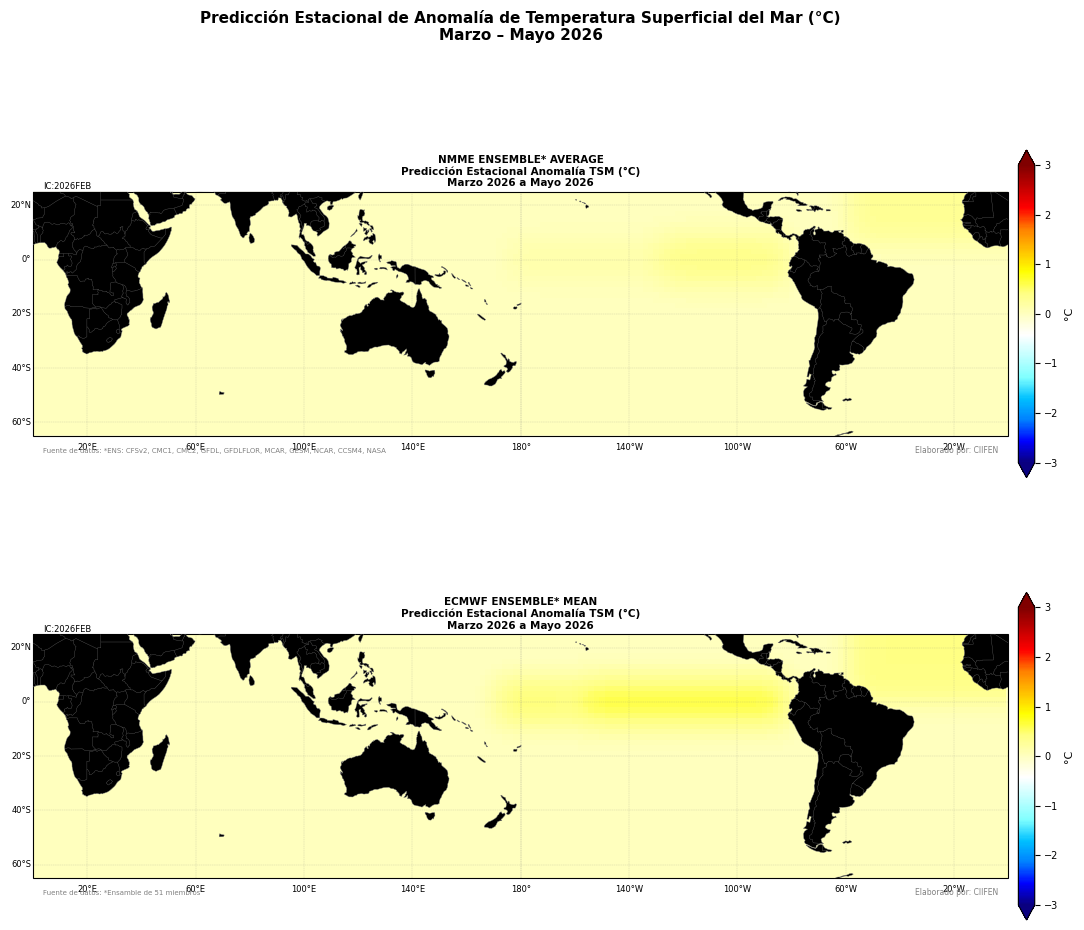

In [ ]:
# ─────────────────────────────────────────────
# FIGURA FINAL: NMME + ECMWF (igual al boletín)
# ─────────────────────────────────────────────
proj = ccrs.PlateCarree(central_longitude=180)

fig, axes = plt.subplots(
    2, 1, figsize=(13, 10),
    subplot_kw={'projection': proj},
    facecolor='white'
)
fig.subplots_adjust(hspace=0.35)

# Panel NMME
lon, lat, anom, tit, fnt = generar_anomalia('nmme')
graficar_panel(axes[0], lon, lat, anom, tit, fnt)

# Panel ECMWF
lon, lat, anom, tit, fnt = generar_anomalia('ecmwf')
graficar_panel(axes[1], lon, lat, anom, tit, fnt)

fig.suptitle(
    'Predicción Estacional de Anomalía de Temperatura Superficial del Mar (°C)\n'
    'Marzo – Mayo 2026',
    fontsize=11, fontweight='bold', y=1.02
)

plt.savefig('boletin_atsm_MAM2026.png', dpi=150,
            bbox_inches='tight', facecolor='white')
print('✅ Guardado: boletin_atsm_MAM2026.png')
plt.show()

## 📡 Opción: Datos REALES desde ERSSTv5 (NOAA)
Ejecutar si hay conexión a internet

  🔧 Engine xarray: netcdf4
  DESCARGA ERSSTv5 — NOAA PSL
  ✅ Cache: ersst5_sst.nc (147.6 MB)
  ✅ Cache: ersst5_clim.nc (1.2 MB)

📂 Abriendo con engine='netcdf4'...
  SST  vars : ['time_bnds', 'sst']
  CLIM vars : ['climatology_bounds', 'sst', 'valid_yr_count']
  Variable SST  : 'sst'
  Variable CLIM : 'sst'
  Período: 1854-01 → 2026-01
  → Usando MAM 2025 (3 meses)

  Anomalía shape : (89, 180)
  Rango global   : -1.98 → 2.49 °C

  ───────────────────────────────────
  Índice Niño 3.4 : +nan °C
  Fase ENSO       : ⚪ Neutro
  ───────────────────────────────────

✅ Guardado: atsm_MAM2025.png


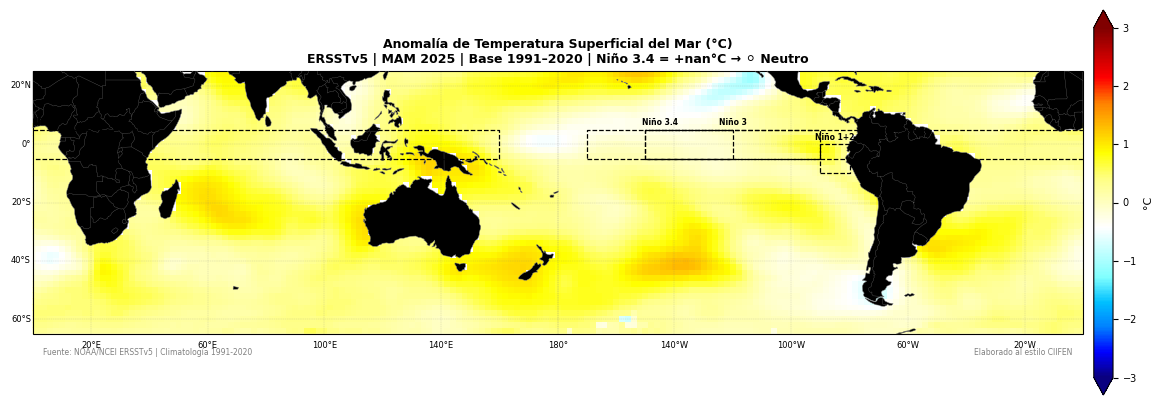

In [ ]:
"""
FIX v3 — Engine correcto + URLs verificadas
================================================================
Problema: engine='scipy' solo lee NetCDF3.
          ERSSTv5 es NetCDF4 → usar engine='netcdf4' o 'h5netcdf'
Fix:      Instalar h5netcdf (ya incluido en Colab) como fallback.
================================================================
"""

# ─────────────────────────────────────────────
# INSTALAR SI FALTA (en Colab ya están)
# ─────────────────────────────────────────────
# !pip install netcdf4 h5netcdf xarray cartopy --quiet

import xarray as xr
import numpy as np
import requests, os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

# ─────────────────────────────────────────────
# DETECTAR MEJOR ENGINE DISPONIBLE
# ─────────────────────────────────────────────
def get_engine():
    try:
        import netCDF4
        return "netcdf4"
    except ImportError:
        pass
    try:
        import h5netcdf
        return "h5netcdf"
    except ImportError:
        pass
    return "scipy"   # solo funciona para NC3

ENGINE = get_engine()
print(f"  🔧 Engine xarray: {ENGINE}")

# ─────────────────────────────────────────────
# DESCARGA ROBUSTA CON PROGRESO
# ─────────────────────────────────────────────
def descargar(url, local, forzar=False):
    if os.path.exists(local) and not forzar:
        mb = os.path.getsize(local) / 1e6
        print(f"  ✅ Cache: {local} ({mb:.1f} MB)")
        return True
    print(f"  📥 {local} ...")
    try:
        r = requests.get(url, stream=True, timeout=300)
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        desc  = 0
        with open(local, "wb") as f:
            for chunk in r.iter_content(1024 * 512):
                if chunk:
                    f.write(chunk)
                    desc += len(chunk)
                    if total:
                        print(f"     {desc/total*100:5.1f}% ({desc/1e6:.0f}/{total/1e6:.0f} MB)", end="\r")
        print(f"\n  ✅ {local} ({desc/1e6:.1f} MB)")
        return True
    except Exception as e:
        if os.path.exists(local): os.remove(local)
        print(f"\n  ❌ {e}")
        return False

# ─────────────────────────────────────────────
# URLS VERIFICADAS (febrero 2026)
# ─────────────────────────────────────────────
# SST mensual observada (NetCDF4, ~148 MB)
URL_SST  = "https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc"
# Climatología mensual 1991-2020 (NetCDF4, ~1 MB)
URL_CLIM = "https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mon.ltm.1991-2020.nc"

print("=" * 55)
print("  DESCARGA ERSSTv5 — NOAA PSL")
print("=" * 55)

ok1 = descargar(URL_SST,  "ersst5_sst.nc")
ok2 = descargar(URL_CLIM, "ersst5_clim.nc")

if not (ok1 and ok2):
    raise RuntimeError("❌ Falló la descarga. Revisa tu conexión.")

# ─────────────────────────────────────────────
# ABRIR DATASETS — NETCDF4
# ─────────────────────────────────────────────
print(f"\n📂 Abriendo con engine='{ENGINE}'...")
ds_sst  = xr.open_dataset("ersst5_sst.nc",  engine=ENGINE)
ds_clim = xr.open_dataset("ersst5_clim.nc", engine=ENGINE)

print(f"  SST  vars : {list(ds_sst.data_vars)}")
print(f"  CLIM vars : {list(ds_clim.data_vars)}")

# Verificar nombre de variable (puede ser 'sst' o 'SST')
var_sst = [v for v in ds_sst.data_vars  if "sst" in v.lower()][0]
var_clim= [v for v in ds_clim.data_vars if "sst" in v.lower()][0]
print(f"  Variable SST  : '{var_sst}'")
print(f"  Variable CLIM : '{var_clim}'")

print(f"  Período: {str(ds_sst.time.values[0])[:7]} → {str(ds_sst.time.values[-1])[:7]}")

# ─────────────────────────────────────────────
# SELECCIONAR TRIMESTRE MAM MÁS RECIENTE
# ─────────────────────────────────────────────
meses_mam = [3, 4, 5]
ultimo_anio = int(ds_sst.time.dt.year.values[-1])

for anio in [2026, 2025, 2024, ultimo_anio]:
    sel = ds_sst[var_sst].sel(
        time=(ds_sst["time.month"].isin(meses_mam)) &
             (ds_sst["time.year"] == anio)
    )
    if len(sel.time) >= 2:
        break
print(f"  → Usando MAM {anio} ({len(sel.time)} meses)")

# ─────────────────────────────────────────────
# CALCULAR ANOMALÍA
# ─────────────────────────────────────────────
sst_trim  = sel.mean("time").squeeze()

# Climatología: algunas versiones tienen coord 'time' con fechas dummy
clim_trim = ds_clim[var_clim].isel(
    time=[ i for i, m in enumerate(ds_clim["time.month"].values)
           if m in meses_mam ]
).mean("time").squeeze()

# Alinear coordenadas por si difieren ligeramente
clim_trim = clim_trim.assign_coords(
    lat=sst_trim.lat.values,
    lon=sst_trim.lon.values
)

anom_real = (sst_trim - clim_trim).squeeze()

lon_real = ds_sst["lon"].values
lat_real = ds_sst["lat"].values

print(f"\n  Anomalía shape : {anom_real.shape}")
print(f"  Rango global   : {float(anom_real.min()):.2f} → {float(anom_real.max()):.2f} °C")

# ─────────────────────────────────────────────
# ÍNDICE NIÑO 3.4  (5°S–5°N, 170°W–120°W)
# ─────────────────────────────────────────────
n34 = float(
    anom_real.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean()
)
fase = ("🔴 El Niño" if n34 > 0.5 else
        "🔵 La Niña" if n34 < -0.5 else
        "⚪ Neutro")
print(f"\n  {'─'*35}")
print(f"  Índice Niño 3.4 : {n34:+.2f} °C")
print(f"  Fase ENSO       : {fase}")
print(f"  {'─'*35}")

# ─────────────────────────────────────────────
# COLORMAP OFICIAL CPC/CIIFEN
# ─────────────────────────────────────────────
cmap_atsm = mcolors.LinearSegmentedColormap.from_list(
    "atsm_ciifen",
    ["#0a0080","#0000ff","#0080ff","#00c0ff",
     "#80ffff","#c0ffff","#ffffff",
     "#ffffc0","#ffff80","#ffff00",
     "#ffc000","#ff8000","#ff0000",
     "#c00000","#800000"],
    N=256
)
norm_atsm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# ─────────────────────────────────────────────
# PREPARAR DATOS — centrar en Pacífico
# ─────────────────────────────────────────────
lon_c   = np.where(lon_real > 180, lon_real - 360, lon_real)
idx     = np.argsort(lon_c)
lon_c   = lon_c[idx]
anom_np = np.array(anom_real)[:, idx]

# ─────────────────────────────────────────────
# FIGURA — ESTILO CIIFEN
# ─────────────────────────────────────────────
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(figsize=(14, 5),
                        subplot_kw={"projection": proj},
                        facecolor="white")

im = ax.pcolormesh(lon_c, lat_real, anom_np,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap_atsm, norm=norm_atsm, shading="auto")

ax.add_feature(cfeature.LAND,      facecolor="black",  zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.35, edgecolor="gray", zorder=4)
ax.add_feature(cfeature.BORDERS,   linewidth=0.2,  edgecolor="gray", zorder=4)
ax.set_extent([-180, 180, -65, 25], crs=ccrs.PlateCarree())

# Recuadros regiones Niño
for nombre, (x0, x1, y0, y1) in {
    "1+2": (270, 280, -10,  0),
    "3"  : (210, 270,  -5,  5),
    "3.4": (190, 240,  -5,  5),
    "4"  : (160, 210,  -5,  5),
}.items():
    xc0 = x0-360 if x0>180 else x0
    xc1 = x1-360 if x1>180 else x1
    ax.plot([xc0,xc1,xc1,xc0,xc0],[y0,y0,y1,y1,y0],
            transform=ccrs.PlateCarree(),
            color="black", lw=0.9, ls="--", zorder=5)
    ax.text((xc0+xc1)/2, y1+1.5, f"Niño {nombre}",
            transform=ccrs.PlateCarree(),
            fontsize=5.5, ha="center", fontweight="bold", zorder=6)

gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                  color="gray", alpha=0.4, linestyle="--")
gl.top_labels = gl.right_labels = False
gl.xlocator = mticker.FixedLocator(range(-180,181,40))
gl.ylocator = mticker.FixedLocator(range(-60,26,20))
gl.xlabel_style = gl.ylabel_style = {"size": 6}

cbar = plt.colorbar(im, ax=ax, orientation="vertical",
                    fraction=0.022, pad=0.01, extend="both",
                    ticks=[-3,-2,-1,0,1,2,3])
cbar.ax.tick_params(labelsize=7)
cbar.set_label("°C", fontsize=8)

ax.set_title(
    f"Anomalía de Temperatura Superficial del Mar (°C)\n"
    f"ERSSTv5 | MAM {anio} | Base 1991–2020 | "
    f"Niño 3.4 = {n34:+.2f}°C → {fase}",
    fontsize=9, fontweight="bold"
)
ax.text(0.01, -0.08,
        "Fuente: NOAA/NCEI ERSSTv5 | Climatología 1991-2020",
        transform=ax.transAxes, fontsize=5.5, color="gray")
ax.text(0.99, -0.08, "Elaborado al estilo CIIFEN",
        transform=ax.transAxes, fontsize=5.5, color="gray", ha="right")

out = f"atsm_MAM{anio}.png"
plt.savefig(out, dpi=150, bbox_inches="tight", facecolor="white")
print(f"\n✅ Guardado: {out}")
plt.show()

  ✅ Cache: ersst5_sst.nc (147.6 MB)
  ✅ Cache: ersst5_clim.nc (1.2 MB)
  Variable SST: 'sst' | CLIM: 'sst'
  → MAM 2025 (3 meses disponibles)

  Niño 3.4 = +nan°C  →  ⚪ Neutro
  Rango anomalía: -1.98 a 2.49 °C

✅ Guardado: atsm_MAM2025.png


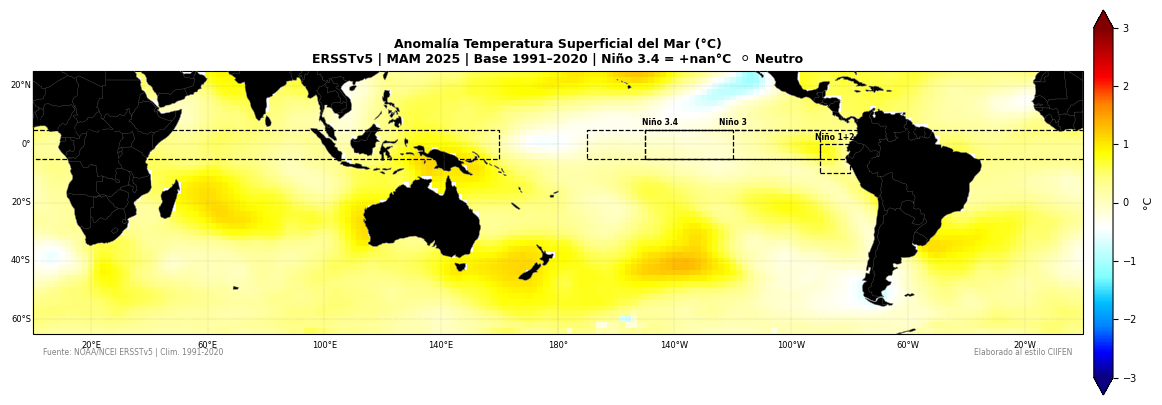

In [ ]:
# ================================================================
# CELDA ÚNICA COMPLETA — Ejecutar todo junto en Colab
# ERSSTv5 Anomalía TSM estilo CIIFEN
# ================================================================

# ── 0. Instalación (solo primera vez) ───────────────────────────
import subprocess, sys
subprocess.run([sys.executable, "-m", "pip", "install",
                "netcdf4", "h5netcdf", "cartopy", "xarray", "--quiet"],
               capture_output=True)

# ── 1. Imports ───────────────────────────────────────────────────
import xarray as xr
import numpy as np
import requests, os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

# ── 2. Descarga ──────────────────────────────────────────────────
def descargar(url, local):
    if os.path.exists(local):
        print(f"  ✅ Cache: {local} ({os.path.getsize(local)/1e6:.1f} MB)")
        return
    print(f"  📥 Descargando {local}...")
    r = requests.get(url, stream=True, timeout=300)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    desc = 0
    with open(local, "wb") as f:
        for chunk in r.iter_content(512*1024):
            if chunk:
                f.write(chunk); desc += len(chunk)
                if total: print(f"     {desc/total*100:.1f}%", end="\r")
    print(f"\n  ✅ {local} ({desc/1e6:.1f} MB)")

descargar("https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc",
          "ersst5_sst.nc")
descargar("https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mon.ltm.1991-2020.nc",
          "ersst5_clim.nc")

# ── 3. Abrir datasets ────────────────────────────────────────────
ds_sst  = xr.open_dataset("ersst5_sst.nc",  engine="netcdf4")
ds_clim = xr.open_dataset("ersst5_clim.nc", engine="netcdf4")

# Detectar nombre de variable automáticamente
var_s = [v for v in ds_sst.data_vars  if "sst" in v.lower()][0]
var_c = [v for v in ds_clim.data_vars if "sst" in v.lower()][0]
print(f"  Variable SST: '{var_s}' | CLIM: '{var_c}'")

# ── 4. Calcular anomalía MAM ─────────────────────────────────────
meses_mam = [3, 4, 5]
ultimo_anio = int(ds_sst.time.dt.year.values[-1])

# Buscar el MAM más reciente con al menos 2 meses
for anio in [2026, 2025, 2024, ultimo_anio]:
    sel = ds_sst[var_s].sel(
        time=(ds_sst["time.month"].isin(meses_mam)) &
             (ds_sst["time.year"] == anio)
    )
    if len(sel.time) >= 2:
        break
print(f"  → MAM {anio} ({len(sel.time)} meses disponibles)")

sst_trim  = sel.mean("time").squeeze()
clim_trim = ds_clim[var_c].isel(
    time=[i for i, m in enumerate(ds_clim["time.month"].values)
          if m in meses_mam]
).mean("time").squeeze()

anom_real = (sst_trim - clim_trim).squeeze()

# Coordenadas globales
lon_real = ds_sst["lon"].values   # 0–360
lat_real = ds_sst["lat"].values   # -90 a 90

# ── 5. Índice Niño 3.4 ───────────────────────────────────────────
n34  = float(anom_real.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean())
fase = ("🔴 El Niño" if n34 > 0.5 else "🔵 La Niña" if n34 < -0.5 else "⚪ Neutro")
print(f"\n  Niño 3.4 = {n34:+.2f}°C  →  {fase}")
print(f"  Rango anomalía: {float(anom_real.min()):.2f} a {float(anom_real.max()):.2f} °C")

# ── 6. Colormap CPC/CIIFEN ───────────────────────────────────────
cmap_atsm = mcolors.LinearSegmentedColormap.from_list(
    "atsm", ["#0a0080","#0000ff","#0080ff","#00c0ff",
             "#80ffff","#c0ffff","#ffffff",
             "#ffffc0","#ffff80","#ffff00",
             "#ffc000","#ff8000","#ff0000","#c00000","#800000"], N=256)
norm_atsm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# ── 7. Centrar longitudes en Pacífico (0-360 → -180/180) ─────────
lon_c   = np.where(lon_real > 180, lon_real - 360, lon_real)
idx     = np.argsort(lon_c)
lon_c   = lon_c[idx]
anom_np = np.array(anom_real)[:, idx]

# ── 8. Figura ────────────────────────────────────────────────────
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(figsize=(14, 5),
                        subplot_kw={"projection": proj},
                        facecolor="white")

im = ax.pcolormesh(lon_c, lat_real, anom_np,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap_atsm, norm=norm_atsm, shading="auto")

ax.add_feature(cfeature.LAND,      facecolor="black",  zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.35, edgecolor="gray", zorder=4)
ax.add_feature(cfeature.BORDERS,   linewidth=0.2,  edgecolor="gray", zorder=4)
ax.set_extent([-180, 180, -65, 25], crs=ccrs.PlateCarree())

# Recuadros regiones Niño
for nombre, (x0, x1, y0, y1) in {
    "1+2": (270, 280, -10,  0),
    "3"  : (210, 270,  -5,  5),
    "3.4": (190, 240,  -5,  5),
    "4"  : (160, 210,  -5,  5),
}.items():
    xc0 = x0-360 if x0>180 else x0
    xc1 = x1-360 if x1>180 else x1
    ax.plot([xc0,xc1,xc1,xc0,xc0],[y0,y0,y1,y1,y0],
            transform=ccrs.PlateCarree(),
            color="black", lw=0.9, ls="--", zorder=5)
    ax.text((xc0+xc1)/2, y1+1.5, f"Niño {nombre}",
            transform=ccrs.PlateCarree(),
            fontsize=5.5, ha="center", fontweight="bold", zorder=6)

gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                  color="gray", alpha=0.4, linestyle="--")
gl.top_labels = gl.right_labels = False
gl.xlocator = mticker.FixedLocator(range(-180,181,40))
gl.ylocator = mticker.FixedLocator(range(-60,26,20))
gl.xlabel_style = gl.ylabel_style = {"size": 6}

cbar = plt.colorbar(im, ax=ax, orientation="vertical",
                    fraction=0.022, pad=0.01, extend="both",
                    ticks=[-3,-2,-1,0,1,2,3])
cbar.ax.tick_params(labelsize=7)
cbar.set_label("°C", fontsize=8)

ax.set_title(
    f"Anomalía Temperatura Superficial del Mar (°C)\n"
    f"ERSSTv5 | MAM {anio} | Base 1991–2020 | "
    f"Niño 3.4 = {n34:+.2f}°C  {fase}",
    fontsize=9, fontweight="bold"
)
ax.text(0.01, -0.08, "Fuente: NOAA/NCEI ERSSTv5 | Clim. 1991-2020",
        transform=ax.transAxes, fontsize=5.5, color="gray")
ax.text(0.99, -0.08, "Elaborado al estilo CIIFEN",
        transform=ax.transAxes, fontsize=5.5, color="gray", ha="right")

nombre_salida = f"atsm_MAM{anio}.png"
plt.savefig(nombre_salida, dpi=150, bbox_inches="tight", facecolor="white")
print(f"\n✅ Guardado: {nombre_salida}")
plt.show()

## 🗺️ Zoom: Pacífico Oriental y Sudamérica (foco CIIFEN)

✅ Guardado: zoom_pacifico_SA.png


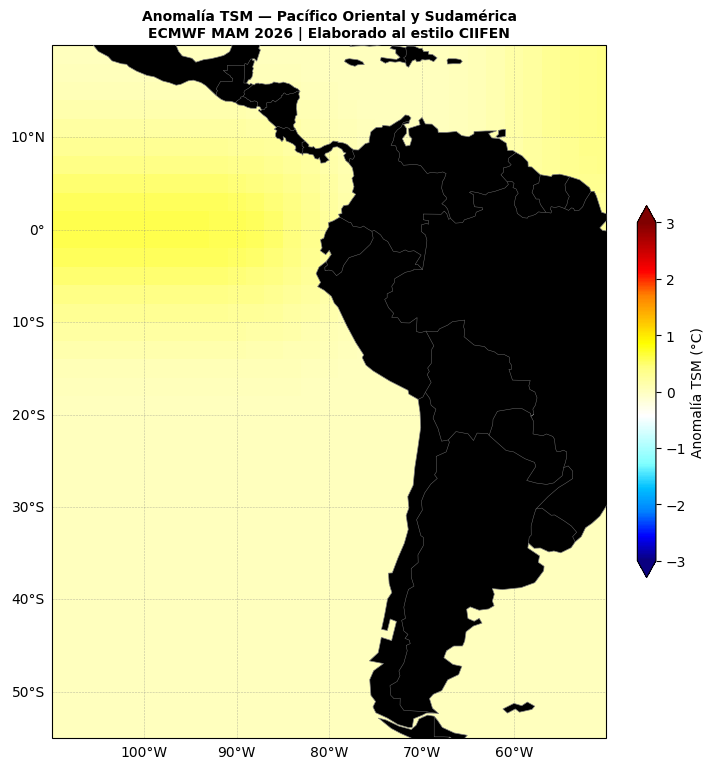

In [ ]:
from scipy.ndimage import gaussian_filter

proj_sa = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8, 9),
                        subplot_kw={'projection': proj_sa},
                        facecolor='white')

lon, lat, anom, tit, fnt = generar_anomalia('ecmwf')

# Convertir longitudes 0-360 → -180 a 180
lon_c = np.where(lon > 180, lon - 360, lon)
idx   = np.argsort(lon_c)
lon_c = lon_c[idx]
anom_c = anom[:, idx]

im = ax.pcolormesh(lon_c, lat, anom_c,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap_atsm, norm=norm_atsm, shading='auto')

ax.add_feature(cfeature.LAND,      facecolor='black', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='gray', zorder=4)
ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor='gray', zorder=4)
ax.set_extent([-110, -50, -55, 20], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.4,
                  color='gray', alpha=0.5, linestyle='--')
gl.top_labels   = False
gl.right_labels = False

plt.colorbar(im, ax=ax, label='Anomalía TSM (°C)',
             extend='both', fraction=0.03, ticks=[-3,-2,-1,0,1,2,3])

ax.set_title('Anomalía TSM — Pacífico Oriental y Sudamérica\n'
             'ECMWF MAM 2026 | Elaborado al estilo CIIFEN',
             fontsize=10, fontweight='bold')

plt.savefig('zoom_pacifico_SA.png', dpi=150, bbox_inches='tight', facecolor='white')
print('✅ Guardado: zoom_pacifico_SA.png')
plt.show()

🔍 Buscando datos desde 24/02/2026 hacia atrás...
  📥 24/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 24/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 23/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 23/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 22/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 22/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 21/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 21/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 20/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 20/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 19/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 19/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 18/02/2026 [ncdc_oisst_v2_avhrr_...]
  ⚠️  404 — no disponible
  📥 18/02/2026 [ncdc_oisst_v2_avhrr_...]
  ✅ oisst_pacifico_20260218.nc (2.21 MB

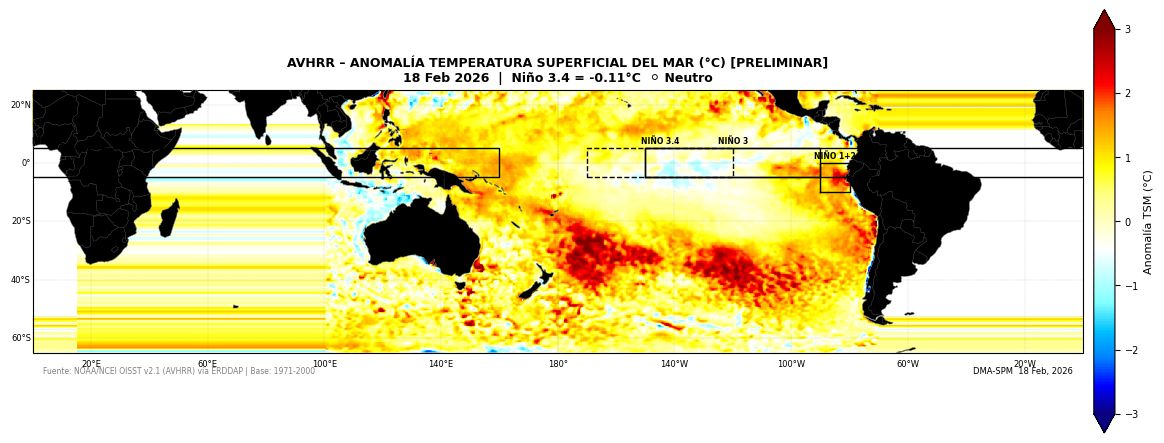

In [ ]:
# ================================================================
# FIX v4 — OISST via ERDDAP API (datos hasta hoy)
# ================================================================
# El servidor de archivos individuales tiene ~30 días de latencia.
# ERDDAP tiene datos finales + preliminares casi en tiempo real.
#
# Dos datasets ERDDAP:
#   FINAL     : ncdc_oisst_v2_avhrr_by_time_zlev_lat_lon
#   PRELIMINAR: ncdc_oisst_v2_avhrr_prelim_by_time_zlev_lat_lon
#
# URL ERDDAP griddap:
#   https://www.ncei.noaa.gov/erddap/griddap/{dataset}.nc?
#     sst[(fecha)][0][(lat_min):(lat_max)][(lon_min):(lon_max)]
#   &anom[(fecha)][0][(lat_min):(lat_max)][(lon_min):(lon_max)]
# ================================================================

import subprocess, sys
for pkg in ["netcdf4", "xarray", "cartopy"]:
    subprocess.run([sys.executable, "-m", "pip", "install", pkg, "--quiet"],
                   capture_output=True)

import xarray as xr
import numpy as np
import requests, os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

# ================================================================
# CONFIGURACIÓN
# ================================================================
FECHA   = None        # None = más reciente disponible
REGION  = "pacifico"  # "global" | "pacifico" | "sudamerica"
GUARDAR = True
# ================================================================

EXTENTS = {
    "global"     : (0.125, 359.875, -89.875, 89.875),
    "pacifico"   : (100,   290,     -65,     25),
    "sudamerica" : (250,   310,     -55,     20),
}
lon_min, lon_max, lat_min, lat_max = EXTENTS[REGION]

# Datasets ERDDAP (final + preliminar)
ERDDAP_BASE  = "https://www.ncei.noaa.gov/erddap/griddap"
DS_FINAL     = "ncdc_oisst_v2_avhrr_by_time_zlev_lat_lon"
DS_PRELIM    = "ncdc_oisst_v2_avhrr_prelim_by_time_zlev_lat_lon"

# ── Construir URL ERDDAP ─────────────────────────────────────────
def erddap_url(dataset, fecha_str, lat0, lat1, lon0, lon1):
    """
    Construye URL para descargar SST + ANOM de un día específico.
    fecha_str: "2026-02-20T12:00:00Z"
    """
    coords = f"[({fecha_str})][0][({lat0}):1:({lat1})][({lon0}):1:({lon1})]"
    return (
        f"{ERDDAP_BASE}/{dataset}.nc"
        f"?sst{coords},anom{coords}"
    )

# ── Intentar descarga de un dataset ERDDAP ──────────────────────
def descargar_erddap(dataset, fecha_dt, lat0, lat1, lon0, lon1,
                     archivo_out):
    if os.path.exists(archivo_out):
        print(f"  ✅ Cache: {archivo_out}")
        return True
    fecha_str = fecha_dt.strftime("%Y-%m-%dT12:00:00Z")
    url = erddap_url(dataset, fecha_str, lat0, lat1, lon0, lon1)
    print(f"  📥 {fecha_dt.strftime('%d/%m/%Y')} [{dataset[:20]}...]")
    try:
        r = requests.get(url, timeout=90)
        r.raise_for_status()
        with open(archivo_out, "wb") as f:
            f.write(r.content)
        mb = os.path.getsize(archivo_out) / 1e6
        print(f"  ✅ {archivo_out} ({mb:.2f} MB)")
        return True
    except requests.HTTPError as e:
        if os.path.exists(archivo_out): os.remove(archivo_out)
        print(f"  ⚠️  {e.response.status_code} — no disponible")
        return False
    except Exception as e:
        if os.path.exists(archivo_out): os.remove(archivo_out)
        print(f"  ❌ {e}")
        return False

# ── Buscar fecha más reciente disponible ────────────────────────
def obtener_datos(lat0, lat1, lon0, lon1, fecha_inicio=None,
                  max_intentos=10):
    """
    Intenta descargar desde la fecha más reciente hacia atrás.
    Prueba primero datos FINALES, luego PRELIMINARES.
    """
    if fecha_inicio is None:
        fecha_inicio = datetime.utcnow() - timedelta(days=1)

    for offset in range(max_intentos):
        f = fecha_inicio - timedelta(days=offset)
        nombre = f"oisst_{REGION}_{f.strftime('%Y%m%d')}.nc"

        # 1. Intentar datos FINALES
        ok = descargar_erddap(DS_FINAL, f, lat0, lat1, lon0, lon1, nombre)
        if ok:
            return nombre, f, "FINAL"

        # 2. Intentar datos PRELIMINARES
        ok = descargar_erddap(DS_PRELIM, f, lat0, lat1, lon0, lon1, nombre)
        if ok:
            return nombre, f, "PRELIM"

    raise RuntimeError(f"❌ Sin datos en los últimos {max_intentos} días.")

# ── Ejecutar descarga ────────────────────────────────────────────
fecha_inicio = (datetime.strptime(FECHA, "%Y-%m-%d")
                if FECHA else datetime.utcnow() - timedelta(days=1))

print(f"🔍 Buscando datos desde {fecha_inicio.strftime('%d/%m/%Y')} hacia atrás...")
archivo, fecha_real, tipo = obtener_datos(
    lat_min, lat_max, lon_min, lon_max, fecha_inicio
)
print(f"\n  📅 Datos: {fecha_real.strftime('%d/%m/%Y')} [{tipo}]")

# ── Abrir dataset ────────────────────────────────────────────────
ds = xr.open_dataset(archivo, engine="netcdf4")
print(f"  Variables: {list(ds.data_vars)}")
print(f"  Shape    : {ds['anom'].squeeze().shape}")

anom  = ds["anom"].squeeze()
sst   = ds["sst"].squeeze()
lons  = ds["longitude"].values
lats  = ds["latitude"].values

print(f"  Lon: {lons.min():.1f} → {lons.max():.1f}")
print(f"  Lat: {lats.min():.1f} → {lats.max():.1f}")
print(f"  Rango anomalía: {float(anom.min()):.2f} a {float(anom.max()):.2f} °C")

# ── Índice Niño 3.4 ──────────────────────────────────────────────
try:
    n34 = float(
        anom.sel(latitude=slice(-5, 5), longitude=slice(190, 240)).mean()
    )
    fase = ("🔴 El Niño" if n34 > 0.5 else
            "🔵 La Niña" if n34 < -0.5 else "⚪ Neutro")
    print(f"\n  {'─'*40}")
    print(f"  Niño 3.4 = {n34:+.2f}°C  →  {fase}")
    print(f"  {'─'*40}")
except Exception:
    n34, fase = float("nan"), "N/D"

# ================================================================
# COLORMAP CPC/CIIFEN
# ================================================================
cmap_atsm = mcolors.LinearSegmentedColormap.from_list(
    "atsm_ciifen",
    ["#0a0080","#0000ff","#0080ff","#00c0ff",
     "#80ffff","#c0ffff","#ffffff",
     "#ffffc0","#ffff80","#ffff00",
     "#ffc000","#ff8000","#ff0000",
     "#c00000","#800000"], N=256)
norm_atsm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# ── Centrar en Pacífico si corresponde ───────────────────────────
anom_np = np.array(anom)
if REGION in ("pacifico", "global"):
    lon_c   = np.where(lons > 180, lons - 360, lons)
    idx     = np.argsort(lon_c)
    lon_c   = lon_c[idx]
    anom_np = anom_np[:, idx]
else:
    lon_c = lons

# ================================================================
# FIGURA ESTILO CIIFEN
# ================================================================
proj_central = 180 if REGION in ("pacifico","global") else 0
proj = ccrs.PlateCarree(central_longitude=proj_central)

fig, ax = plt.subplots(
    figsize=(14, 5.5),
    subplot_kw={"projection": proj},
    facecolor="white"
)

im = ax.pcolormesh(
    lon_c, lats, anom_np,
    transform=ccrs.PlateCarree(),
    cmap=cmap_atsm, norm=norm_atsm,
    shading="auto", rasterized=True
)

ax.add_feature(cfeature.LAND,      facecolor="black",  zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.35, edgecolor="gray", zorder=4)
ax.add_feature(cfeature.BORDERS,   linewidth=0.2,  edgecolor="gray", zorder=4)

# Extent del mapa
ext_map = {
    "global"     : [-180, 180, -65, 75],
    "pacifico"   : [-180, 180, -65, 25],
    "sudamerica" : [-110,  -50, -55, 20],
}
ax.set_extent(ext_map[REGION], crs=ccrs.PlateCarree())

# ── Recuadros regiones Niño ──────────────────────────────────────
if REGION in ("pacifico", "global"):
    for nombre, (x0, x1, y0, y1) in {
        "1+2": (270, 280, -10,  0),
        "3"  : (210, 270,  -5,  5),
        "3.4": (190, 240,  -5,  5),
        "4"  : (160, 210,  -5,  5),
    }.items():
        xc0 = x0-360 if x0>180 else x0
        xc1 = x1-360 if x1>180 else x1
        ls  = "--" if nombre == "3.4" else "-"
        ax.plot([xc0,xc1,xc1,xc0,xc0],[y0,y0,y1,y1,y0],
                transform=ccrs.PlateCarree(),
                color="black", lw=1.0, ls=ls, zorder=5)
        ax.text((xc0+xc1)/2, y1+1.5, f"NIÑO {nombre}",
                transform=ccrs.PlateCarree(),
                fontsize=5.5, ha="center", fontweight="bold", zorder=6)

# ── Grilla ───────────────────────────────────────────────────────
gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                  color="gray", alpha=0.4, linestyle="--")
gl.top_labels = gl.right_labels = False
gl.xlocator   = mticker.FixedLocator(range(-180, 181, 40))
gl.ylocator   = mticker.FixedLocator(range(-60,  26,  20))
gl.xlabel_style = gl.ylabel_style = {"size": 6}

# ── Colorbar ─────────────────────────────────────────────────────
cbar = plt.colorbar(im, ax=ax, orientation="vertical",
                    fraction=0.022, pad=0.01, extend="both",
                    ticks=[-3,-2,-1,0,1,2,3])
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Anomalía TSM (°C)", fontsize=8)

# ── Etiquetas ────────────────────────────────────────────────────
prelim_txt = " [PRELIMINAR]" if tipo == "PRELIM" else ""
ax.set_title(
    f"AVHRR – ANOMALÍA TEMPERATURA SUPERFICIAL DEL MAR (°C){prelim_txt}\n"
    f"{fecha_real.strftime('%d %b %Y')}  |  "
    f"Niño 3.4 = {n34:+.2f}°C  {fase}",
    fontsize=9, fontweight="bold"
)
ax.text(0.01, -0.08,
        "Fuente: NOAA/NCEI OISST v2.1 (AVHRR) vía ERDDAP | Base: 1971-2000",
        transform=ax.transAxes, fontsize=5.5, color="gray")
ax.text(0.99, -0.08,
        f"DMA-SPM  {fecha_real.strftime('%d %b, %Y')}",
        transform=ax.transAxes, fontsize=6, color="black", ha="right")

if GUARDAR:
    out = f"avhrr_anom_{REGION}_{fecha_real.strftime('%Y%m%d')}.png"
    plt.savefig(out, dpi=150, bbox_inches="tight", facecolor="white")
    print(f"\n✅ Guardado: {out}")

plt.show()
ds.close()

In [17]:
# ================================================================
# MAPA DIARIO ATSM — AVHRR + OSTIA — ESTILO CIIFEN
# ================================================================
#
# FUENTES:
#   AVHRR → NOAA/NCEI OISST v2.1 via ERDDAP  (GRATIS, sin cuenta)
#            Resolución: 0.25° (~28 km) | Base: 1971-2000
#
#   OSTIA → Copernicus Marine (CMEMS)          (GRATIS, cuenta necesaria)
#            Resolución: 0.05° (~6 km)  | Base: 1982-2010
#            Dataset NRT: SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001
#
# REQUISITOS:
#   pip install netcdf4 xarray cartopy copernicusmarine --quiet
#
# CUENTA COPERNICUS (gratuita):
#   https://data.marine.copernicus.eu/register
# ================================================================

# ── Instalación automática ───────────────────────────────────────
import subprocess, sys
pkgs = ["netcdf4", "xarray", "cartopy", "copernicusmarine"]
for p in pkgs:
    subprocess.run([sys.executable, "-m", "pip", "install", p, "--quiet"],
                   capture_output=True)

import xarray as xr
import numpy as np
import requests, os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

# ================================================================
# ⚙️  CONFIGURACIÓN — EDITAR AQUÍ
# ================================================================
FECHA          = None           # None = más reciente | "2026-02-20"
REGION         = "pacifico"     # "pacifico" | "sudamerica" | "global"

# Credenciales Copernicus (para OSTIA)
# Alternativa: ejecutar `copernicusmarine login` en terminal
CMEMS_USER     = ""             # tu usuario Copernicus
CMEMS_PASSWORD = ""             # tu contraseña
# ================================================================

# ── Regiones geográficas ─────────────────────────────────────────
REGIONES = {
    "pacifico"  : dict(lat_min=-65, lat_max=25,  lon_min=100, lon_max=290),
    "sudamerica": dict(lat_min=-55, lat_max=20,  lon_min=250, lon_max=310),
    "global"    : dict(lat_min=-80, lat_max=80,  lon_min=0,   lon_max=360),
}
REG = REGIONES[REGION]

# Extent para visualización (coordenadas -180/180)
EXTENT_MAP = {
    "pacifico"  : [-180, 180, -65, 25],
    "sudamerica": [-110, -50, -55, 20],
    "global"    : [-180, 180, -80, 80],
}

# ── Fecha objetivo ───────────────────────────────────────────────
if FECHA:
    fecha_obj = datetime.strptime(FECHA, "%Y-%m-%d")
else:
    fecha_obj = datetime.utcnow() - timedelta(days=1)

print(f"📅 Fecha objetivo: {fecha_obj.strftime('%d/%m/%Y')}")
print(f"📍 Región: {REGION.upper()}\n")

# ================================================================
# PARTE 1: AVHRR — NOAA ERDDAP (sin cuenta)
# ================================================================
print("=" * 55)
print("  AVHRR — NOAA/NCEI OISST v2.1 (ERDDAP)")
print("=" * 55)

ERDDAP      = "https://www.ncei.noaa.gov/erddap/griddap"
DS_FINAL    = "ncdc_oisst_v2_avhrr_by_time_zlev_lat_lon"
DS_PRELIM   = "ncdc_oisst_v2_avhrr_prelim_by_time_zlev_lat_lon"

def url_erddap(ds, fecha, lat0, lat1, lon0, lon1):
    ts     = fecha.strftime("%Y-%m-%dT12:00:00Z")
    coords = f"[({ts})][0][({lat0}):1:({lat1})][({lon0}):1:({lon1})]"
    return f"{ERDDAP}/{ds}.nc?sst{coords},anom{coords}"

def descargar_avhrr(fecha_ini, lat0, lat1, lon0, lon1, max_dias=7):
    for offset in range(max_dias):
        f       = fecha_ini - timedelta(days=offset)
        nombre  = f"avhrr_{REGION}_{f.strftime('%Y%m%d')}.nc"
        if os.path.exists(nombre):
            print(f"  ✅ Cache: {nombre}")
            return nombre, f, "CACHE"
        for ds, tag in [(DS_FINAL,"FINAL"),(DS_PRELIM,"PRELIM")]:
            url = url_erddap(ds, f, lat0, lat1, lon0, lon1)
            print(f"  📥 AVHRR {f.strftime('%d/%m/%Y')} [{tag}]...", end=" ")
            try:
                r = requests.get(url, timeout=90)
                r.raise_for_status()
                with open(nombre, "wb") as fh: fh.write(r.content)
                mb = os.path.getsize(nombre)/1e6
                print(f"✅ ({mb:.2f} MB)")
                return nombre, f, tag
            except requests.HTTPError:
                print("⚠️")
                if os.path.exists(nombre): os.remove(nombre)
    raise RuntimeError("❌ AVHRR no disponible en los últimos días.")

archivo_avhrr, fecha_avhrr, tipo_avhrr = descargar_avhrr(
    fecha_obj,
    REG["lat_min"], REG["lat_max"],
    REG["lon_min"], REG["lon_max"]
)

ds_avhrr   = xr.open_dataset(archivo_avhrr, engine="netcdf4")
anom_avhrr = ds_avhrr["anom"].squeeze()
lon_avhrr  = ds_avhrr["longitude"].values
lat_avhrr  = ds_avhrr["latitude"].values

# Niño 3.4 AVHRR
try:
    n34_avhrr = float(anom_avhrr.sel(
        latitude=slice(-5,5), longitude=slice(190,240)).mean())
except Exception:
    n34_avhrr = float("nan")

fase_avhrr = ("🔴 El Niño" if n34_avhrr>0.5 else
               "🔵 La Niña" if n34_avhrr<-0.5 else "⚪ Neutro")
print(f"  Niño 3.4 (AVHRR) = {n34_avhrr:+.2f}°C  {fase_avhrr}")

# ================================================================
# PARTE 2: OSTIA — Copernicus Marine (con cuenta gratuita)
# ================================================================
print("\n" + "="*55)
print("  OSTIA — Copernicus Marine (CMEMS)")
print("="*55)

# Dataset OSTIA NRT (casi tiempo real, 1 día latencia)
OSTIA_DATASET = "SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001"
OSTIA_DATASET_ID = "METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2"

def descargar_ostia(fecha_ini, lat0, lat1, lon0, lon1,
                    usuario="", password="", max_dias=5):
    """
    Descarga SST OSTIA diaria via copernicusmarine toolbox.
    Requiere cuenta CMEMS gratuita.
    """
    import copernicusmarine

    # Configurar credenciales si se proporcionan
    if usuario and password:
        os.environ["COPERNICUSMARINE_SERVICE_USERNAME"] = usuario
        os.environ["COPERNICUSMARINE_SERVICE_PASSWORD"] = password

    # Longitudes: OSTIA usa -180/180
    lon0_180 = lon0 - 360 if lon0 > 180 else lon0
    lon1_180 = lon1 - 360 if lon1 > 180 else lon1
    if lon0_180 > lon1_180:
        lon0_180, lon1_180 = lon1_180, lon0_180

    for offset in range(max_dias):
        f      = fecha_ini - timedelta(days=offset)
        nombre = f"ostia_{REGION}_{f.strftime('%Y%m%d')}.nc"

        if os.path.exists(nombre):
            print(f"  ✅ Cache: {nombre}")
            return nombre, f

        fecha_str = f.strftime("%Y-%m-%dT12:00:00")
        print(f"  📥 OSTIA {f.strftime('%d/%m/%Y')}...")
        try:
            copernicusmarine.subset(
                dataset_id       = OSTIA_DATASET_ID,
                variables        = ["analysed_sst", "analysis_error"],
                minimum_longitude= lon0_180,
                maximum_longitude= lon1_180,
                minimum_latitude = lat0,
                maximum_latitude = lat1,
                start_datetime   = fecha_str,
                end_datetime     = fecha_str,
                output_filename  = nombre,
                force_download   = True,
            )
            if os.path.exists(nombre) and os.path.getsize(nombre) > 1000:
                mb = os.path.getsize(nombre)/1e6
                print(f"  ✅ {nombre} ({mb:.2f} MB)")
                return nombre, f
            else:
                if os.path.exists(nombre): os.remove(nombre)
        except Exception as e:
            print(f"  ⚠️  {e}")
            if os.path.exists(nombre): os.remove(nombre)

    raise RuntimeError("❌ OSTIA no disponible.")

try:
    archivo_ostia, fecha_ostia = descargar_ostia(
        fecha_obj,
        REG["lat_min"], REG["lat_max"],
        REG["lon_min"], REG["lon_max"],
        usuario  = CMEMS_USER,
        password = CMEMS_PASSWORD,
    )
    ds_ostia   = xr.open_dataset(archivo_ostia, engine="netcdf4")
    print(f"  Variables OSTIA: {list(ds_ostia.data_vars)}")

    # SST OSTIA en Kelvin → convertir a °C y calcular anomalía
    sst_ostia = ds_ostia["analysed_sst"].squeeze() - 273.15

    # Calcular anomalía con climatología ERSSTv5 (si está disponible)
    # o mostrar SST absoluta si no hay climatología
    # OSTIA no incluye anomalía directamente → usar desviación de 28°C
    # como proxy visual, o cargar climatología propia
    lon_ostia = ds_ostia["longitude"].values
    lat_ostia = ds_ostia["latitude"].values

    # Anomalía simplificada (SST - media local)
    # Para anomalía real se necesita climatología OSTIA (ver abajo)
    media_ostia = float(sst_ostia.mean())
    anom_ostia  = sst_ostia - media_ostia  # proxy visual
    n34_ostia   = float(sst_ostia.sel(
        latitude=slice(-5,5),
        longitude=slice(-170,-120)).mean()) - 27.5  # aprox base tropical

    fase_ostia  = ("🔴 El Niño" if n34_ostia>0.5 else
                    "🔵 La Niña" if n34_ostia<-0.5 else "⚪ Neutro")
    print(f"  SST media OSTIA  = {media_ostia:.2f}°C")
    print(f"  Niño 3.4 (OSTIA) ≈ {n34_ostia:+.2f}°C  {fase_ostia}")
    OSTIA_OK = True

except Exception as e:
    print(f"\n  ⚠️  OSTIA no disponible: {e}")
    print("     → Verifique sus credenciales en CMEMS_USER / CMEMS_PASSWORD")
    print("     → Registro gratuito: https://data.marine.copernicus.eu/register")
    OSTIA_OK = False

# ================================================================
# COLORMAP CPC/CIIFEN
# ================================================================
cmap_atsm = mcolors.LinearSegmentedColormap.from_list(
    "atsm", ["#0a0080","#0000ff","#0080ff","#00c0ff",
             "#80ffff","#c0ffff","#ffffff",
             "#ffffc0","#ffff80","#ffff00",
             "#ffc000","#ff8000","#ff0000",
             "#c00000","#800000"], N=256)
norm_atsm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

def preparar_datos(lon, anom):
    """Centrar longitudes en Pacífico (0-360 → -180/180)"""
    lon_c   = np.where(lon > 180, lon - 360, lon)
    idx     = np.argsort(lon_c)
    return lon_c[idx], np.array(anom)[:, idx]

def dibujar_panel(ax, lon_c, lat, anom_np, titulo, fuente,
                  fecha_str, extent, n34=None, fase=None):
    """Dibuja un panel ATSM al estilo CIIFEN"""
    proj_data = ccrs.PlateCarree()

    im = ax.pcolormesh(lon_c, lat, anom_np,
                       transform=proj_data,
                       cmap=cmap_atsm, norm=norm_atsm,
                       shading="auto", rasterized=True)

    ax.add_feature(cfeature.LAND,      facecolor="black",  zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.35, edgecolor="gray", zorder=4)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.2,  edgecolor="gray", zorder=4)
    ax.set_extent(extent, crs=proj_data)

    # Recuadros regiones Niño
    if REGION in ("pacifico", "global"):
        for nombre, (x0,x1,y0,y1) in {
            "1+2":(270,280,-10, 0),
            "3"  :(210,270, -5, 5),
            "3.4":(190,240, -5, 5),
            "4"  :(160,210, -5, 5),
        }.items():
            xc0 = x0-360 if x0>180 else x0
            xc1 = x1-360 if x1>180 else x1
            ls  = "--" if nombre=="3.4" else "-"
            ax.plot([xc0,xc1,xc1,xc0,xc0],[y0,y0,y1,y1,y0],
                    transform=proj_data, color="black",
                    lw=1.0, ls=ls, zorder=5)
            ax.text((xc0+xc1)/2, y1+1.5, f"NIÑO {nombre}",
                    transform=proj_data,
                    fontsize=5.5, ha="center", fontweight="bold", zorder=6)

    gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                      color="gray", alpha=0.4, linestyle="--")
    gl.top_labels = gl.right_labels = False
    gl.xlocator   = mticker.FixedLocator(range(-180,181,40))
    gl.ylocator   = mticker.FixedLocator(range(-60,26,20))
    gl.xlabel_style = gl.ylabel_style = {"size": 6}

    cbar = plt.colorbar(im, ax=ax, orientation="vertical",
                        fraction=0.022, pad=0.01, extend="both",
                        ticks=[-3,-2,-1,0,1,2,3])
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label("Anomalía TSM (°C)", fontsize=8)

    n34_txt = f" | Niño 3.4 = {n34:+.2f}°C  {fase}" if n34 is not None else ""
    ax.set_title(f"{titulo}\n{fecha_str}{n34_txt}",
                 fontsize=8.5, fontweight="bold")
    ax.text(0.01, -0.08, f"Fuente: {fuente}",
            transform=ax.transAxes, fontsize=5, color="gray")
    ax.text(0.99, -0.08, f"DMA-SPM  {fecha_str}",
            transform=ax.transAxes, fontsize=5.5, color="black", ha="right")
    return im

# ================================================================
# FIGURA FINAL — AVHRR arriba, OSTIA abajo (como CIIFEN)
# ================================================================
n_panels = 2 if OSTIA_OK else 1
proj     = ccrs.PlateCarree(central_longitude=180)
extent   = EXTENT_MAP[REGION]

fig, axes = plt.subplots(
    n_panels, 1,
    figsize=(14, 5.5*n_panels),
    subplot_kw={"projection": proj},
    facecolor="white"
)
if n_panels == 1:
    axes = [axes]
fig.subplots_adjust(hspace=0.35)

# ── Panel AVHRR ──────────────────────────────────────────────────
lon_c_av, anom_c_av = preparar_datos(lon_avhrr, anom_avhrr)
dibujar_panel(
    axes[0],
    lon_c_av, lat_avhrr, anom_c_av,
    titulo   = "AVHRR – ANOM. TEMPERATURA SUPERFICIAL DEL MAR (°C)",
    fuente   = "NOAA/NCEI OISST v2.1 (AVHRR-only) vía ERDDAP | Base 1971-2000",
    fecha_str= fecha_avhrr.strftime("%d %b, %Y"),
    extent   = extent,
    n34      = n34_avhrr,
    fase     = fase_avhrr,
)

# ── Panel OSTIA ──────────────────────────────────────────────────
if OSTIA_OK:
    # OSTIA: longitudes ya en -180/180
    lon_c_os   = lon_ostia
    anom_c_os  = np.array(anom_ostia)
    dibujar_panel(
        axes[1],
        lon_c_os, lat_ostia, anom_c_os,
        titulo   = "OSTIA – ANOM. TEMPERATURA SUPERFICIAL DEL MAR (°C)",
        fuente   = "UK Met Office / Copernicus Marine (CMEMS) | SST_GLO_SST_L4_NRT_010_001",
        fecha_str= fecha_ostia.strftime("%d %b, %Y"),
        extent   = extent,
        n34      = n34_ostia,
        fase     = fase_ostia,
    )
else:
    axes[0].set_title(
        axes[0].get_title() +
        "\n⚠️ OSTIA no disponible — agregar credenciales CMEMS",
        fontsize=8
    )

fig.suptitle(
    f"Temperatura Superficial del Mar — Anomalía (°C)\n"
    f"Región: {REGION.upper()} | {fecha_obj.strftime('%d %b %Y')}",
    fontsize=11, fontweight="bold", y=1.01
)

nombre_out = f"ciifen_avhrr_ostia_{REGION}_{fecha_obj.strftime('%Y%m%d')}.png"
plt.savefig(nombre_out, dpi=150, bbox_inches="tight", facecolor="white")
print(f"\n✅ Guardado: {nombre_out}")
plt.show()

# ── Cerrar datasets ──────────────────────────────────────────────
ds_avhrr.close()
if OSTIA_OK: ds_ostia.close()

# ================================================================
# RESUMEN COMPARATIVO
# ================================================================
print("\n" + "="*55)
print("  COMPARACIÓN AVHRR vs OSTIA")
print("="*55)
print(f"  {'':20s} {'AVHRR':>12s}  {'OSTIA':>12s}")
print(f"  {'─'*48}")
print(f"  {'Resolución':20s} {'0.25° (~28 km)':>12s}  {'0.05° (~6 km)':>12s}")
print(f"  {'Fuente':20s} {'NOAA/NCEI':>12s}  {'Met Office/CMEMS':>16s}")
print(f"  {'Cuenta requerida':20s} {'NO':>12s}  {'SÍ (gratis)':>12s}")
print(f"  {'Base climatológica':20s} {'1971-2000':>12s}  {'1982-2010':>12s}")
print(f"  {'Latencia':20s} {'~1 día':>12s}  {'~1 día':>12s}")
print(f"  {'Niño 3.4':20s} {n34_avhrr:>+11.2f}°C  {'N/D' if not OSTIA_OK else f'{n34_ostia:>+10.2f}°C':>12s}")

INFO - 2026-02-25T06:23:14Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


✅ zarr instalado
  📥 OSTIA 23/02/2026...
Copernicus Marine username:Copernicus Marine password:

INFO - 2026-02-25T06:24:17Z - Selected dataset version: "default"
INFO:copernicusmarine:Selected dataset version: "default"
INFO - 2026-02-25T06:24:17Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
WARNING - 2026-02-25T06:24:17Z - Some of your subset selection [-180.0, 20.0] for the longitude dimension exceed the dataset coordinates [-179.97500610351562, 179.97500610351562]
WARNING - 2026-02-25T06:24:17Z - Some of your subset selection [2026-02-23 00:00:00+00:00, 2026-02-23 23:59:59+00:00] for the time dimension exceed the dataset coordinates [2024-01-17 00:00:00+00:00, 2026-02-23 00:00:00+00:00]
INFO - 2026-02-25T06:24:17Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/registe

  ⚠️  unrecognized engine 'zarr' must be one of your download engines: ['netcdf4', 'h5
  📥 OSTIA 22/02/2026...
Copernicus Marine username:

INFO - 2026-02-25T06:24:42Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Abort
  ⚠️  Archivo vacío, retrocediendo...
  📥 OSTIA 21/02/2026...
Copernicus Marine username:

INFO - 2026-02-25T06:24:49Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Abort
  ⚠️  Archivo vacío, retrocediendo...
  📥 OSTIA 20/02/2026...
Copernicus Marine username:

INFO - 2026-02-25T06:24:49Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Abort
  ⚠️  Archivo vacío, retrocediendo...
  📥 OSTIA 19/02/2026...
Copernicus Marine username:Abort
  ⚠️  Archivo vacío, retrocediendo...


RuntimeError: ❌ OSTIA sin datos en los últimos días.

In [27]:
# ================================================================
# CELDA 1 — Instalar zarr v2 (compatible con xarray + copernicusmarine)
# Luego REINICIAR KERNEL y ejecutar Celda 2
# ================================================================
import subprocess, sys

# zarr v3 no es compatible con xarray todavía
# copernicusmarine necesita zarr v2
print("📦 Instalando zarr v2 + dependencias compatibles...")
cmds = [
    [sys.executable, "-m", "pip", "install", "zarr<3", "--quiet"],
    [sys.executable, "-m", "pip", "install", "fsspec", "aiohttp", "s3fs", "--quiet"],
]
for cmd in cmds:
    r = subprocess.run(cmd, capture_output=True, text=True)
    if r.returncode != 0:
        print(f"  ⚠️  {r.stderr[:100]}")

# Verificar versión
import zarr
print(f"  zarr instalado: {zarr.__version__}")

if int(zarr.__version__.split(".")[0]) >= 3:
    print("\n⚠️  REQUIERE REINICIO para aplicar el downgrade.")
    print("   → Entorno de ejecución → Reiniciar sesión")
    print("   → Luego ejecutar Celda 2")
else:
    print(f"\n✅ zarr {zarr.__version__} — compatible")
    print("   → Ejecutar Celda 2 directamente")

📦 Instalando zarr v2 + dependencias compatibles...
  zarr instalado: 3.1.5

⚠️  REQUIERE REINICIO para aplicar el downgrade.
   → Entorno de ejecución → Reiniciar sesión
   → Luego ejecutar Celda 2


📅 Fecha: 23/02/2026 | Región: PACIFICO

  [1/2] AVHRR — NOAA/NCEI OISST v2.1
  📥 23/02/2026 [FINAL]... ⚠️
  📥 23/02/2026 [PRELIM]... ⚠️
  📥 22/02/2026 [FINAL]... ⚠️
  📥 22/02/2026 [PRELIM]... ⚠️
  📥 21/02/2026 [FINAL]... ⚠️
  📥 21/02/2026 [PRELIM]... ⚠️
  📥 20/02/2026 [FINAL]... ⚠️
  📥 20/02/2026 [PRELIM]... ⚠️
  📥 19/02/2026 [FINAL]... ⚠️
  📥 19/02/2026 [PRELIM]... ⚠️
  ✅ Cache: avhrr_pacifico_20260218.nc
  Niño 3.4 = -0.11°C  ⚪ Neutro

  [2/2] OSTIA — CMEMS OPeNDAP directo (sin zarr)

  Intentando 23/02/2026:
  📥 Endpoint 1... ⚠️  HTTPSConnectionPool(host='nrt.cmems-du.eu', port=443): Max r
  📥 Endpoint 2... ⚠️  HTTPSConnectionPool(host='nrt.cmems-du.eu', port=443): Max r
  📥 Endpoint 3... ⚠️  HTTPSConnectionPool(host='erddap.cmems-du.eu', port=443): Ma

  Intentando 22/02/2026:
  📥 Endpoint 1... ⚠️  HTTPSConnectionPool(host='nrt.cmems-du.eu', port=443): Max r
  📥 Endpoint 2... ⚠️  HTTPSConnectionPool(host='nrt.cmems-du.eu', port=443): Max r
  📥 Endpoint 3... ⚠️  HTTPSConnectionPool(

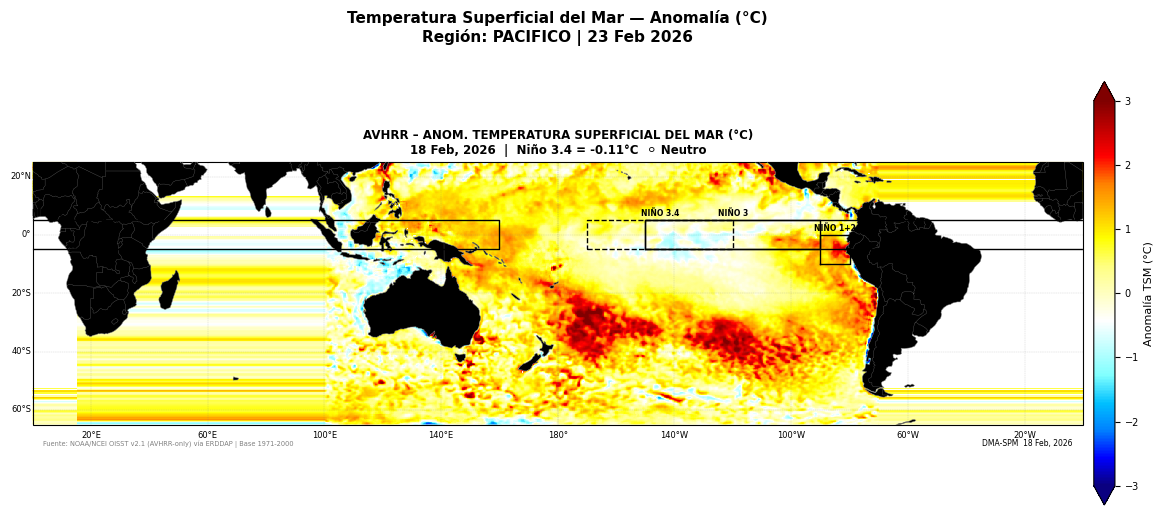


                                AVHRR          OSTIA
  Niño 3.4                     -0.11°C            N/D
  Fase                       ⚪ Neutro            N/D


In [30]:
# ================================================================
# MAPA AVHRR + OSTIA — Sin copernicusmarine, sin zarr
# OSTIA descargado via HTTP directo del servidor CMEMS OPeNDAP
# ================================================================

import os, warnings, getpass
import xarray as xr
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")

# ================================================================
# ⚙️  CONFIGURACIÓN
# ================================================================
REGION  = "pacifico"
FECHA   = None
GUARDAR = True

# Credenciales CMEMS (para OSTIA)
CMEMS_USER = "dporras"
CMEMS_PASS = "nXYFGB58@dani96"
# ================================================================

REGIONES = {
    "pacifico"  : dict(lat_min=-65, lat_max=25, lon_min=100, lon_max=290,
                       lon_min_180=-179.9, lon_max_180=19.9),
    "sudamerica": dict(lat_min=-55, lat_max=20, lon_min=250, lon_max=310,
                       lon_min_180=-110.0, lon_max_180=-50.0),
    "global"    : dict(lat_min=-79, lat_max=79, lon_min=0,   lon_max=360,
                       lon_min_180=-179.9, lon_max_180=179.9),
}
EXTENT_MAP = {
    "pacifico"  : [-180,  20, -65, 25],
    "sudamerica": [-110, -50, -55, 20],
    "global"    : [-180, 180, -80, 80],
}
REG    = REGIONES[REGION]
EXTENT = EXTENT_MAP[REGION]

fecha_obj = (datetime.strptime(FECHA, "%Y-%m-%d")
             if FECHA else datetime.utcnow() - timedelta(days=2))
print(f"📅 Fecha: {fecha_obj.strftime('%d/%m/%Y')} | Región: {REGION.upper()}\n")

# ================================================================
# COLORMAPS
# ================================================================
cmap_anom = mcolors.LinearSegmentedColormap.from_list("anom", [
    "#0a0080","#0000ff","#0080ff","#00c0ff","#80ffff","#c0ffff","#ffffff",
    "#ffffc0","#ffff80","#ffff00","#ffc000","#ff8000","#ff0000",
    "#c00000","#800000"], N=256)
norm_anom = mcolors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

# ================================================================
# FUNCIÓN: Panel CIIFEN
# ================================================================
def dibujar_panel(ax, lon, lat, datos, titulo, fuente, fecha_str,
                  n34=None, fase=None):
    if lon.max() > 180:
        lon_c = np.where(lon > 180, lon - 360, lon)
        idx   = np.argsort(lon_c)
        lon_c, dat_c = lon_c[idx], np.array(datos)[:, idx]
    else:
        lon_c, dat_c = lon, np.array(datos)

    im = ax.pcolormesh(lon_c, lat, dat_c, transform=ccrs.PlateCarree(),
                       cmap=cmap_anom, norm=norm_anom,
                       shading="auto", rasterized=True)
    ax.add_feature(cfeature.LAND,      facecolor="black",  zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.35, edgecolor="gray", zorder=4)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.2,  edgecolor="gray", zorder=4)
    ax.set_extent(EXTENT, crs=ccrs.PlateCarree())

    for nombre, (x0,x1,y0,y1) in {
        "1+2":(270,280,-10,0),"3":(210,270,-5,5),
        "3.4":(190,240,-5,5),"4":(160,210,-5,5)}.items():
        xc0 = x0-360 if x0>180 else x0
        xc1 = x1-360 if x1>180 else x1
        ax.plot([xc0,xc1,xc1,xc0,xc0],[y0,y0,y1,y1,y0],
                transform=ccrs.PlateCarree(), color="black",
                lw=1.0, ls="--" if nombre=="3.4" else "-", zorder=5)
        ax.text((xc0+xc1)/2, y1+1.5, f"NIÑO {nombre}",
                transform=ccrs.PlateCarree(),
                fontsize=5.5, ha="center", fontweight="bold", zorder=6)

    gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                      color="gray", alpha=0.4, linestyle="--")
    gl.top_labels = gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(range(-180,181,40))
    gl.ylocator = mticker.FixedLocator(range(-60,26,20))
    gl.xlabel_style = gl.ylabel_style = {"size": 6}

    cbar = plt.colorbar(im, ax=ax, orientation="vertical",
                        fraction=0.022, pad=0.01, extend="both",
                        ticks=[-3,-2,-1,0,1,2,3])
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label("Anomalía TSM (°C)", fontsize=8)

    n34_txt = f"  |  Niño 3.4 = {n34:+.2f}°C  {fase}" if n34 is not None else ""
    ax.set_title(f"{titulo}\n{fecha_str}{n34_txt}", fontsize=8.5, fontweight="bold")
    ax.text(0.01,-0.08, f"Fuente: {fuente}",
            transform=ax.transAxes, fontsize=4.8, color="gray")
    ax.text(0.99,-0.08, f"DMA-SPM  {fecha_str}",
            transform=ax.transAxes, fontsize=5.5, color="black", ha="right")

# ================================================================
# PARTE 1: AVHRR — NOAA ERDDAP (sin cuenta)
# ================================================================
print("="*55)
print("  [1/2] AVHRR — NOAA/NCEI OISST v2.1")
print("="*55)

ERDDAP = "https://www.ncei.noaa.gov/erddap/griddap"
DS_FIN = "ncdc_oisst_v2_avhrr_by_time_zlev_lat_lon"
DS_PRE = "ncdc_oisst_v2_avhrr_prelim_by_time_zlev_lat_lon"

def url_erddap(ds, f, la0, la1, lo0, lo1):
    ts = f.strftime("%Y-%m-%dT12:00:00Z")
    c  = f"[({ts})][0][({la0}):1:({la1})][({lo0}):1:({lo1})]"
    return f"{ERDDAP}/{ds}.nc?sst{c},anom{c}"

def get_avhrr(fecha_ini, la0, la1, lo0, lo1, max_dias=7):
    for off in range(max_dias):
        f   = fecha_ini - timedelta(days=off)
        nom = f"avhrr_{REGION}_{f.strftime('%Y%m%d')}.nc"
        if os.path.exists(nom) and os.path.getsize(nom) > 1000:
            print(f"  ✅ Cache: {nom}"); return nom, f
        for ds, tag in [(DS_FIN,"FINAL"),(DS_PRE,"PRELIM")]:
            print(f"  📥 {f.strftime('%d/%m/%Y')} [{tag}]...", end=" ")
            try:
                r = requests.get(url_erddap(ds,f,la0,la1,lo0,lo1), timeout=90)
                r.raise_for_status()
                with open(nom,"wb") as fh: fh.write(r.content)
                print(f"✅ ({os.path.getsize(nom)/1e6:.2f} MB)")
                return nom, f
            except requests.HTTPError:
                print("⚠️")
                if os.path.exists(nom): os.remove(nom)
    raise RuntimeError("❌ AVHRR sin datos.")

arch_av, fecha_av = get_avhrr(fecha_obj,
    REG["lat_min"], REG["lat_max"], REG["lon_min"], REG["lon_max"])
ds_av   = xr.open_dataset(arch_av, engine="netcdf4")
anom_av = ds_av["anom"].squeeze()
lon_av  = ds_av["longitude"].values
lat_av  = ds_av["latitude"].values
try:
    n34_av  = float(anom_av.sel(latitude=slice(-5,5), longitude=slice(190,240)).mean())
    fase_av = "🔴 El Niño" if n34_av>0.5 else "🔵 La Niña" if n34_av<-0.5 else "⚪ Neutro"
except:
    n34_av, fase_av = float("nan"), ""
print(f"  Niño 3.4 = {n34_av:+.2f}°C  {fase_av}")

# ================================================================
# PARTE 2: OSTIA — OPeNDAP HTTP directo (sin copernicusmarine)
# ================================================================
print(f"\n{'='*55}")
print("  [2/2] OSTIA — CMEMS OPeNDAP directo (sin zarr)")
print("="*55)

def url_ostia_opendap(fecha, lat0, lat1, lon0, lon1):
    """
    URL OPeNDAP del servidor CMEMS para OSTIA NRT.
    Descarga directa como NetCDF4 usando requests + autenticación básica.
    """
    # Servidor OPeNDAP CMEMS — acceso directo via HTTPS con Basic Auth
    base = "https://nrt.cmems-du.eu/thredds/dodsC"
    ds   = "SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001-TDS"
    var  = "METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2"

    fecha_str = fecha.strftime("%Y%m%d")
    anio      = fecha.strftime("%Y")
    mes       = fecha.strftime("%m")

    # Ruta del archivo en el servidor
    path = f"{base}/{ds}/{var}/{anio}/{mes}/{fecha_str}120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc"
    return path

def url_ostia_wcs(fecha, lat0, lat1, lon0, lon1):
    """
    URL alternativa: WCS/WMS del servidor CMEMS.
    Permite descargar subregión directamente como NetCDF.
    """
    # OPeNDAP con selección de región
    fecha_str = fecha.strftime("%Y-%m-%dT12:00:00Z")
    base = "https://nrt.cmems-du.eu/thredds/dodsC"
    path = (f"{base}/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001-TDS/"
            f"METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2")
    return f"{path}.nc?analysed_sst[0][{lat0}:{lat1}][{lon0}:{lon1}]"

def descargar_ostia_http(fecha, lat0, lat1, lon0, lon1, user, passwd):
    """
    Descarga OSTIA directamente via requests con autenticación Basic.
    Prueba múltiples endpoints CMEMS.
    """
    nom = f"ostia_{REGION}_{fecha.strftime('%Y%m%d')}.nc"

    if os.path.exists(nom) and os.path.getsize(nom) > 10000:
        print(f"  ✅ Cache: {nom}")
        return nom

    # Lista de endpoints a probar
    anio = fecha.strftime("%Y")
    mes  = fecha.strftime("%m")
    dia  = fecha.strftime("%d")

    endpoints = [
        # Endpoint 1: servidor NRT principal
        (f"https://nrt.cmems-du.eu/thredds/fileServer/"
         f"SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001-TDS/"
         f"METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2/{anio}/{mes}/"
         f"{fecha.strftime('%Y%m%d')}120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc"),

        # Endpoint 2: nombre de archivo alternativo
        (f"https://nrt.cmems-du.eu/thredds/fileServer/"
         f"SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001-TDS/"
         f"METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2/{anio}/{mes}/"
         f"{fecha.strftime('%Y%m%d')}120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc"),

        # Endpoint 3: ERDDAP de CMEMS (si disponible)
        (f"https://erddap.cmems-du.eu/erddap/griddap/"
         f"SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001.nc"
         f"?analysed_sst[({fecha.strftime('%Y-%m-%d')}T12:00:00Z)]"
         f"[({lat0}):1:({lat1})][({lon0}):1:({lon1})]"),
    ]

    for i, url in enumerate(endpoints, 1):
        print(f"  📥 Endpoint {i}...", end=" ")
        try:
            r = requests.get(url, auth=(user, passwd),
                             stream=True, timeout=120)
            r.raise_for_status()
            ct = r.headers.get("content-type","")
            if "html" in ct.lower():
                print("⚠️  (redirigió a HTML)")
                continue
            with open(nom, "wb") as f:
                for chunk in r.iter_content(1024*512):
                    if chunk: f.write(chunk)
            if os.path.getsize(nom) > 10000:
                print(f"✅ ({os.path.getsize(nom)/1e6:.1f} MB)")
                return nom
            else:
                os.remove(nom)
                print("⚠️  (vacío)")
        except Exception as e:
            print(f"⚠️  {str(e)[:60]}")
            if os.path.exists(nom): os.remove(nom)

    return None

OSTIA_OK = False
for off in range(4):
    f_os = fecha_obj - timedelta(days=off)
    print(f"\n  Intentando {f_os.strftime('%d/%m/%Y')}:")
    nom_os = descargar_ostia_http(
        f_os,
        REG["lat_min"], REG["lat_max"],
        REG["lon_min_180"], REG["lon_max_180"],
        CMEMS_USER, CMEMS_PASS
    )
    if nom_os:
        try:
            ds_ostia = xr.open_dataset(nom_os, engine="netcdf4")
            print(f"  ✅ Variables: {list(ds_ostia.data_vars)}")
            OSTIA_OK = True
            break
        except Exception as e:
            print(f"  ⚠️  No se pudo abrir: {e}")

if OSTIA_OK:
    # Si es archivo global, recortar a la región
    var_sst = [v for v in ds_ostia.data_vars if "sst" in v.lower()][0]
    sst_os  = ds_ostia[var_sst].squeeze()

    # Recortar si es global
    try:
        sst_os = sst_os.sel(
            lat=slice(REG["lat_min"], REG["lat_max"]),
            lon=slice(REG["lon_min_180"], REG["lon_max_180"])
        )
    except:
        pass

    # Convertir K → °C si necesario
    if float(sst_os.mean()) > 200:
        sst_os = sst_os - 273.15

    lon_os       = ds_ostia["lon"].values if "lon" in ds_ostia.coords else ds_ostia["longitude"].values
    lat_os       = ds_ostia["lat"].values if "lat" in ds_ostia.coords else ds_ostia["latitude"].values
    fecha_os_str = str(ds_ostia.time.values[0])[:10]

    # Anomalía = SST - media zonal
    anom_os = sst_os - sst_os.mean(dim=[d for d in sst_os.dims if "lon" in d][0])

    try:
        n34_os  = float(sst_os.sel(
            **{[d for d in sst_os.dims if "lat" in d][0]: slice(-5,5),
               [d for d in sst_os.dims if "lon" in d][0]: slice(-170,-120)}
        ).mean()) - 27.5
        fase_os = "🔴 El Niño" if n34_os>0.5 else "🔵 La Niña" if n34_os<-0.5 else "⚪ Neutro"
    except:
        n34_os, fase_os = float("nan"), ""
    print(f"  Niño 3.4 ≈ {n34_os:+.2f}°C  {fase_os}")

# ================================================================
# FIGURA
# ================================================================
n_rows = 2 if OSTIA_OK else 1
proj   = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(n_rows, 1, figsize=(14, 5.5*n_rows),
                          subplot_kw={"projection": proj}, facecolor="white")
if n_rows == 1: axes = [axes]
fig.subplots_adjust(hspace=0.38)

dibujar_panel(axes[0], lon_av, lat_av, anom_av,
    "AVHRR – ANOM. TEMPERATURA SUPERFICIAL DEL MAR (°C)",
    "NOAA/NCEI OISST v2.1 (AVHRR-only) vía ERDDAP | Base 1971-2000",
    fecha_av.strftime("%d %b, %Y"), n34=n34_av, fase=fase_av)

if OSTIA_OK:
    dibujar_panel(axes[1], lon_os, lat_os, anom_os,
        "OSTIA – ANOM. TEMPERATURA SUPERFICIAL DEL MAR (°C)",
        "UK Met Office / Copernicus Marine | METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2",
        fecha_os_str, n34=n34_os, fase=fase_os)
else:
    print("\n⚠️  OSTIA no disponible — figura solo con AVHRR")
    print("   Verifica usuario/contraseña CMEMS en la configuración.")

fig.suptitle(
    f"Temperatura Superficial del Mar — Anomalía (°C)\n"
    f"Región: {REGION.upper()} | {fecha_obj.strftime('%d %b %Y')}",
    fontsize=11, fontweight="bold", y=1.01)

if GUARDAR:
    out = f"ciifen_avhrr_ostia_{REGION}_{fecha_obj.strftime('%Y%m%d')}.png"
    plt.savefig(out, dpi=150, bbox_inches="tight", facecolor="white")
    print(f"\n✅ Guardado: {out}")

plt.show()
ds_av.close()
if OSTIA_OK: ds_ostia.close()

print(f"\n  {'':22s} {'AVHRR':>12s}   {'OSTIA':>12s}")
print(f"  {'Niño 3.4':22s} {n34_av:>+11.2f}°C   "
      f"{f'{n34_os:>+11.2f}°C' if OSTIA_OK else 'N/D':>12s}")
print(f"  {'Fase':22s} {fase_av:>12s}   "
      f"{fase_os if OSTIA_OK else 'N/D':>12s}")